## Reproduces Figure 3 in Lauer et al., Nature Methods 2022

In [1]:
import cv2
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import plot_single_image_keypoints

%matplotlib inline

In [ ]:
!pip install --upgrade matplotlib

### Figure 3, top

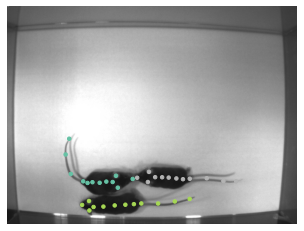

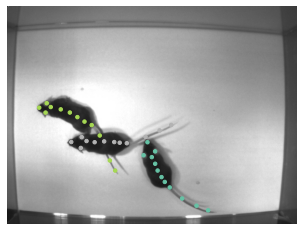

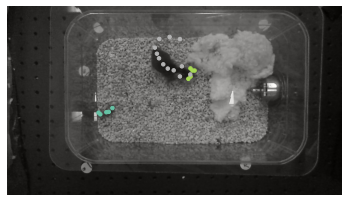

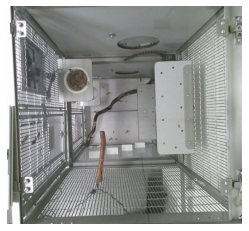

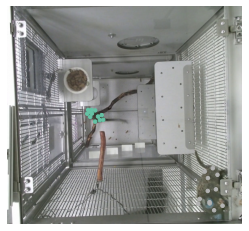

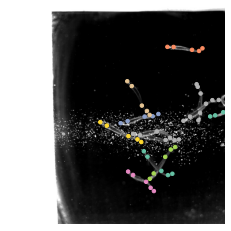

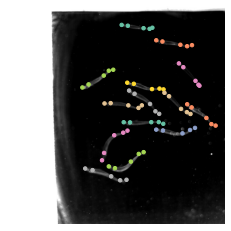

In [2]:
cmap = 'Set2'
ms = 12

plot_single_image_keypoints(
    '../data/fig3/mouse_0.h5', '../data/fig3/mouse_0.jpg',
    ms, cmap, output_name='mouse_a.jpg',
)
plot_single_image_keypoints(
    '../data/fig3/mouse_1.h5', '../data/fig3/mouse_1.jpg',
    ms, cmap, output_name='mouse_b.jpg',
)

plot_single_image_keypoints(
    '../data/fig3/pups_0.h5', '../data/fig3/pups_0.jpg',
    ms, cmap, output_name='pups_a.jpg',
)

plot_single_image_keypoints(
    '../data/fig3/marmo_0.h5', '../data/fig3/marmo_0.jpg',
    ms, cmap, output_name='marmosets_a.jpg',
)
plot_single_image_keypoints(
    '../data/fig3/marmo_1.h5', '../data/fig3/marmo_1.jpg',
    ms, cmap, output_name='marmosets_b.jpg',
)

plot_single_image_keypoints(
    '../data/fig3/fish_0.h5', '../data/fig3/fish_0.jpg',
    ms, cmap, output_name='fish_a.jpg',
)
plot_single_image_keypoints(
    '../data/fig3/fish_1.h5', '../data/fig3/fish_1.jpg',
    ms, cmap, output_name='fish_b.jpg',
)

### Fig 3a

In [3]:
def plot_3d_tracks(df, colormap="Set3", downsample=1, stretch=1, videofile=""):
    df = df.copy().iloc[::downsample]
    time = np.arange(len(df))
    # Compute track centroids
    centroids = []
    for _, group in df.groupby("individuals", axis=1):
        centroids.append(group.mean(level="coords", axis=1).values)
    n_centroids = len(centroids)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
    ax.set_box_aspect((1, stretch, 1))
    ax.grid(False)
    ax.azim = -40
    ax.elev = 20
    cmap = plt.cm.get_cmap(colormap, n_centroids)
    colors = cmap(range(n_centroids))
    for centroid, color in zip(centroids, colors):
        xy = centroid[:, :2]
        ax.plot(
            *xy.T,
            time,
            zdir="y",
            color=color,
            zorder=3,
        )
    ax.zaxis._axinfo["juggled"] = 1, 2, 0  # Hack to plot the vertical axis to the left

    if videofile:
        stream = cv2.VideoCapture(videofile)
        _, first_frame = stream.read()
        first_frame = first_frame[..., ::-1] / 255
        last_pos = df.shape[0] - 1
        stream.set(cv2.CAP_PROP_POS_FRAMES, last_pos)
        _, last_frame = stream.read()
        last_frame = last_frame[..., ::-1] / 255
        xx, zz = np.meshgrid(
            np.arange(first_frame.shape[1]), np.arange(first_frame.shape[0])
        )
        yy = np.ones_like(xx)
        stride = xx.shape[0] // 100
        ax.plot_surface(
            xx,
            yy - 1,
            zz,
            rstride=stride,
            cstride=stride,
            facecolors=first_frame,
            shade=False,
            alpha=0.4,
            zorder=2,
        )
        ax.plot_surface(
            xx,
            yy * last_pos,
            zz,
            rstride=stride,
            cstride=stride,
            facecolors=last_frame,
            shade=False,
            alpha=0.4,
            zorder=-1,
        )

    ax.set_xlabel("$x$", labelpad=-10)
    ax.set_ylabel("$Time$", labelpad=20)
    ax.set_zlabel("$y$", labelpad=-10)
    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    ax.set_ylim((0, time.max()))
    ax.invert_zaxis()
    fig.tight_layout()
    return fig, ax

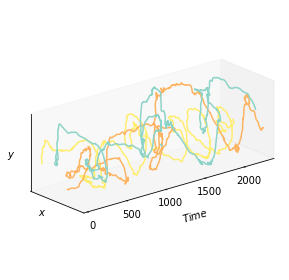

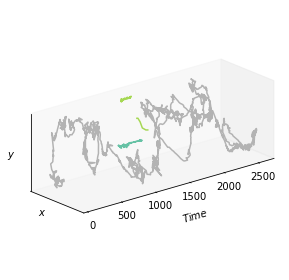

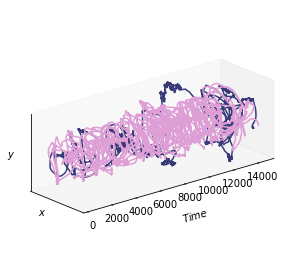

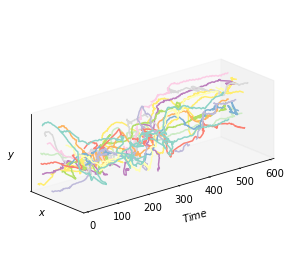

In [4]:
stretch = 3
dpi = 600

###### DLC predictions ######
# please note, the benchmark includes tracking, thus ground truth is currently NOT provided

fig, _ = plot_3d_tracks(
    pd.read_hdf('../data/fig3/mouse_track.h5'),
    'Set3_r',
    stretch=stretch,
)
fig.savefig('track_trimice_dlc.jpg', dpi=dpi)
#plt.close(fig)

fig, _ = plot_3d_tracks(
    pd.read_hdf('../data/fig3/pups_track.h5').iloc[:-1],
    'Set2',
    stretch=stretch,
)
fig.savefig('track_pups_dlc.jpg', dpi=dpi)
#plt.close(fig)

fig, _ = plot_3d_tracks(
    pd.read_hdf('../data/fig3/marmo_track.h5'),
    'tab20b',
    stretch=stretch,
)
fig.savefig(f'track_marmosets_dlc.jpg', dpi=dpi)
#plt.close(fig)

fig, _ = plot_3d_tracks(
    pd.read_hdf('../data/fig3/fish_track.h5'),
    'Set3_r',
    stretch=stretch,
)
fig.savefig('track_fish_dlc.jpg', dpi=dpi)
#plt.close(fig)

### Fig 3e

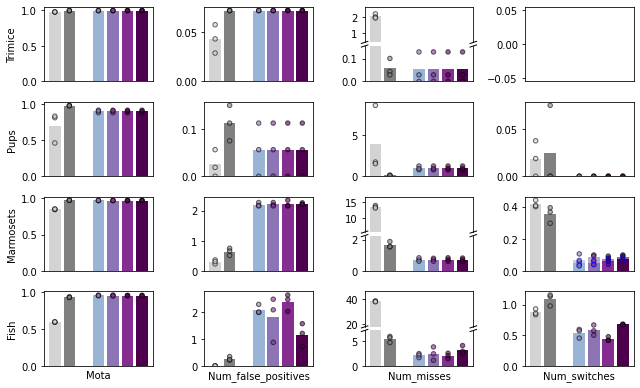

In [5]:
nframes = {'mouse': 2330, 'pup': 2672, 'marmo': 15000, 'fish': 600}
nindivs = {'mouse': 3, 'pup': 2, 'marmo': 2, 'fish': 14}
labels = ['mota', 'num_false_positives', 'num_misses', 'num_switches']
order = ['baseline', 'shape', 'dist', 'motion', 'dyna']
nbars = len(order)
inds = [0, 1] + list(range(3, 2 + nbars))
colormap = 'BuPu'
cmap = plt.cm.get_cmap(colormap, nbars + 1)
colors = cmap(range(nbars + 2))
colors[0] = mc.to_rgba('lightgray')
colors[1] = mc.to_rgba('gray')

df = pd.read_hdf('../data/fig3/mota.h5')

fig, axes = plt.subplots(4, len(labels), tight_layout=True, sharex='all', figsize=(9, 5.5))
axes[0, 0].set_xticks([])

for row, dataset in enumerate(['mouse', 'pup', 'marmo', 'fish']):
    temp = (df[df['dataset'] == dataset]
            .set_index(['metrics', 'tracker', 'dataset', 'shuffle'])
            .reindex(order, level=0)
            .droplevel('dataset'))
    temp[['num_false_positives', 'num_misses', 'num_switches']
            ] /= nframes[dataset] * nindivs[dataset] / 100
    bars = temp.groupby(by=['metrics', 'tracker']).mean()
    for col, label in enumerate(labels):
        axes[row, col].bar(inds, bars[label].to_numpy(),
                            color=colors, zorder=-1, alpha=1)
        vals = temp[label].reindex(
            ['box', 'ellipse'], level='tracker').to_numpy()
        if vals.sum() > 0:
            axes[row, col].scatter(
                np.repeat(inds, 3), vals, color=np.repeat(colors[[0, 1, 3, 4, 5, 6]], 3, axis=0),
                ec='black', lw=1, alpha=0.6, s=20,
            )
        if label in ('num_misses', 'num_switches') and vals.sum() > 0:
            if label == 'num_switches' and row in (1, 2, 3):
                continue
            if label == 'num_misses' and row == 1:
                continue
            divider = make_axes_locatable(axes[row, col])
            axes[row, col].spines['top'].set_visible(False)
            ax2 = divider.new_vertical(size='100%', pad=0.05)
            fig.add_axes(ax2)
            ax2.bar(inds, bars[label].to_numpy(),
                    color=colors, zorder=-1, alpha=1)
            ax2.scatter(
                np.repeat(inds, 3), vals, color=np.repeat(colors[[0, 1, 3, 4, 5, 6]], 3, axis=0),
                ec='black', lw=1, alpha=0.6, s=20,
            )
            ax2.tick_params(bottom=False, labelbottom=False)
            ax2.spines['bottom'].set_visible(False)
            d = 0.03
            kwargs = dict(transform=ax2.transAxes,
                            color='k', clip_on=False, lw=1)
            ax2.plot((-d, +d), (-d, +d), **kwargs)
            ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)
            kwargs.update(transform=axes[row, col].transAxes)
            axes[row, col].plot((-d, +d), (1 - d, 1 + d), **kwargs)
            axes[row, col].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
            axes[row, col].set_ylim(0, 1.2 * vals[3:].max())
            ax2.set_ylim(3 * vals[3:].max(), 1.2 * vals[:3].max())

for rect in axes[2, -1].patches[2:]:
    rect.set_alpha(0.6)
vals = [o + '+id' for o in order[1:]]
temp = (df[(df['dataset'] == 'marmo') & (df['tracker'] == 'ellipse')]
        .drop('tracker', axis=1)
        .set_index(['metrics', 'dataset', 'shuffle'])
        .reindex(vals, level=0))
axes[2, -1].bar(inds[2:], (temp['num_switches'] / nframes['marmo'] * 100 / 2).groupby('metrics').mean().to_numpy(),
                color=colors[2:], zorder=-1, alpha=1)
axes[2, -1].scatter(
    np.repeat(inds[2:], 3), temp['num_switches'] / nframes['marmo'] * 100 / 2, color=np.repeat(colors[[3, 4, 5, 6]], 3, axis=0),
    ec='b', lw=1, alpha=0.6, s=20
)

axes[0, 0].set_ylabel('Trimice')
axes[1, 0].set_ylabel('Pups')
axes[2, 0].set_ylabel('Marmosets')
axes[3, 0].set_ylabel('Fish')

for i, label in enumerate(labels):
    axes[-1, i].set_xlabel(label.capitalize())

fig.savefig('fig3e.jpg', dpi=600)